In [1]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter, medfilt, butter, filtfilt
import matplotlib.pyplot as plt
import lib.noise_test as noise

# Player Data Technical Assessment

## Load data

In [2]:
df = pd.read_csv('./data/match_data.csv')
df

,participation_id,Time (s),Pitch_x,Pitch_y,Speed (m/s)
0,455426a2-5604-4c3a-8b89-ed0519f8d77a,0.0,-18.977667,-38.511021,0.060
1,685d721f-fb27-4fb6-a327-6c8b420bf47f,0.0,-18.740459,-37.195089,0.039
2,8d6885e6-bfa9-4561-820c-f80eac8d7f62,0.0,-14.467439,-38.767767,0.036
3,455426a2-5604-4c3a-8b89-ed0519f8d77a,0.1,-18.977667,-38.511021,0.071
4,685d721f-fb27-4fb6-a327-6c8b420bf47f,0.1,-18.737733,-37.179963,0.019
...,...,...,...,...,...
985269,8d6885e6-bfa9-4561-820c-f80eac8d7f62,6597.0,-15.021545,-44.366125,0.006
985270,a7cc7c2e-350d-47a3-9d76-e40bc7cffa9e,6597.0,-16.524369,-42.599752,0.026
985271,b2d99dc2-6919-4c70-b381-6f89ca52048d,6597.0,-20.258575,-43.086796,0.030
985272,ball,6597.0,11.824754,-32.202406,0.000


## Initial stats

In [3]:
participation_ids = df['participation_id'].unique().tolist()
sample_weights = df['participation_id'].value_counts().reindex(participation_ids).to_numpy()

number_of_tracked_items = len(participation_ids)
group_by_participation = df.groupby('participation_id')
mean_entries_per_participation = np.round(group_by_participation.size().mean(), 2)
std_entries_per_participation = np.round(group_by_participation.size().std(), 2)

print('number of tracked items (incl. ball): ', number_of_tracked_items)
print('mean entries per participation: ', mean_entries_per_participation)
print('std entries per participation: ', std_entries_per_participation)

number of tracked items (incl. ball):  17
mean entries per participation:  57957.29
std entries per participation:  6456.29


In [4]:
# For each player, compute the sample rate
# This is the total number of samples divided by the total time for that player
# also compute the max time difference between samples
# add them together in a weighted average where the weight is the number of samples

running_total_sample_rate = 0
total_number_of_samples = 0
sample_rates = []

for sample_id in participation_ids:
    sample_times = df[df['participation_id'] == sample_id]['Time (s)'].values
    time_max = np.max(sample_times)
    time_min = np.min(sample_times)
    time_diff = time_max - time_min

    number_of_samples = len(sample_times)
    total_number_of_samples += number_of_samples

    sample_rate = number_of_samples / time_diff
    running_total_sample_rate += sample_rate * number_of_samples
    sample_rates.append(sample_rate)

mean_sample_rate = running_total_sample_rate / total_number_of_samples

# Compute weighted standard deviation for sample rates
sample_rates = np.array(sample_rates)
sample_weights = np.array(sample_weights)
weighted_mean = np.average(sample_rates, weights=sample_weights)
weighted_variance = np.average((sample_rates - weighted_mean) ** 2, weights=sample_weights)
weighted_std = np.sqrt(weighted_variance)

print(f"Estimated mean sample rate: {mean_sample_rate:.2f} ±{weighted_std:.2f} Hz")

Estimated mean sample rate: 9.04 ±0.76 Hz


## Constants

In [5]:
SAMPLE_RATE = 9

PITCH_X_MIN = -52.5
PITCH_X_MAX = +52.5
PITCH_Y_MIN = -34
PITCH_Y_MAX = 34

MAX_SPEED_PLAYER = 12
MAX_ACCEL_PLAYER = 8
MAX_DECEL_PLAYER = -9
REST_THRESHOLD_PLAYER = 0.5

MAX_SPEED_BALL = 12
MAX_ACCEL_BALL = 70
MAX_DECEL_BALL = -80
REST_THRESHOLD_BALL = 0.2

## Determine noise


Ball
Rest acceleration jitter: 2.5 m/s²
Bad acceleration percentage: 0.98%

Weighted Player
Rest acceleration jitter: 0.75 m/s²
Bad acceleration percentage: 0.65%


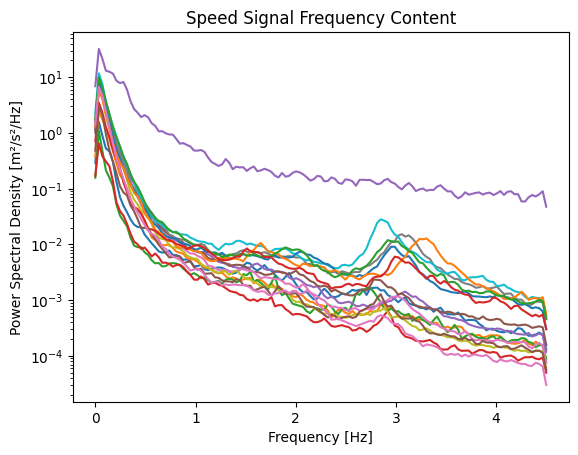

In [6]:
import lib.noise_test as noise

def calculate_noise_metrics(df):
    running_weighted_rest_jitter = 0
    running_weighted_bad_acceleration_percentage = 0
    total_number_of_samples = 0

    for pid in participation_ids:
        is_ball = (pid == 'ball')
        participant_df = df[df['participation_id'] == pid]

        if is_ball:
            rest_acceleration_jitter = noise.rest_acceleration_jitter(
                participant_df['Speed (m/s)'], participant_df['Time (s)'], 
                rest_threshold=REST_THRESHOLD_BALL
            )
            bad_acceleration_percentage = noise.bad_acceleration_percentage(
                participant_df['Speed (m/s)'], participant_df['Time (s)'],
                max_accel=MAX_ACCEL_BALL, max_decel=MAX_DECEL_BALL
            )
            print(f"\nBall")
            print(f"Rest acceleration jitter: {rest_acceleration_jitter:.2} m/s²")
            print(f"Bad acceleration percentage: {bad_acceleration_percentage:.2f}%")
        else:
            participant_number_of_samples = participant_df.shape[0]

            rest_acceleration_jitter = noise.rest_acceleration_jitter(
                participant_df['Speed (m/s)'], participant_df['Time (s)'],
                rest_threshold=REST_THRESHOLD_PLAYER
            )
            bad_acceleration_percentage = noise.bad_acceleration_percentage(
                participant_df['Speed (m/s)'], participant_df['Time (s)'],
                max_accel=MAX_ACCEL_PLAYER, max_decel=MAX_DECEL_PLAYER
            )
            running_weighted_rest_jitter += rest_acceleration_jitter * participant_number_of_samples
            running_weighted_bad_acceleration_percentage += bad_acceleration_percentage * participant_number_of_samples
            total_number_of_samples += participant_number_of_samples    

        noise.power_spectral_density(participant_df['Time (s)'], participant_df['Speed (m/s)'], target_sample_rate=SAMPLE_RATE)

    print(f"\nWeighted Player")
    print(f"Rest acceleration jitter: {running_weighted_rest_jitter / total_number_of_samples:.2} m/s²")
    print(f"Bad acceleration percentage: {running_weighted_bad_acceleration_percentage / total_number_of_samples:.2f}%")

calculate_noise_metrics(df)

## Data processing


In [7]:
import lib.filtering as filtering

filtered_df = pd.DataFrame()

for pid in participation_ids:
    is_ball = (pid == 'ball')
    participant_df = df[df['participation_id'] == pid]
    filtered_participant_df = pd.DataFrame()


    if is_ball:
        # filter speed based on physical limits
        speed_outlier_removed, _ = filtering.physical_limits_outlier_removal(
            participant_df['Speed (m/s)'], participant_df['Time (s)'],
            max_speed=MAX_SPEED_BALL, max_accel=MAX_ACCEL_BALL, max_decel=MAX_DECEL_BALL
        )

        # interpolate to uniform sampling rate
        time_uniform, speed_uniform, pitch_x_uniform, pitch_y_uniform = filtering.interpolate_to_uniform(
            participant_df['Time (s)'], speed_outlier_removed,
            participant_df['Pitch_x'], participant_df['Pitch_y'],
            target_sample_rate=SAMPLE_RATE
        )

        # filter speed based on butterworth filter
        speed_filtered = filtering.butterworth_filter(
            speed_uniform, 
            cutoff_freq=4.4, fs=SAMPLE_RATE, order=4
        )

        # filter position based on savgol filter
        pitch_x_filtered, pitch_y_filtered = filtering.savgol_filter(
            pitch_x_uniform, pitch_y_uniform,
            window_length=7, poly_order=2
        )

        filtered_participant_df['participation_id'] = [pid]*len(time_uniform)
        filtered_participant_df['Time (s)'] = time_uniform
        filtered_participant_df['Speed (m/s)'] = speed_filtered
        filtered_participant_df['Pitch_x'] = pitch_x_filtered
        filtered_participant_df['Pitch_y'] = pitch_y_filtered
        
    else:
        # filter speed based on physical limits
        speed_outlier_removed, _ = filtering.physical_limits_outlier_removal(
            participant_df['Speed (m/s)'], participant_df['Time (s)'],
            max_speed=MAX_SPEED_PLAYER, max_accel=MAX_ACCEL_PLAYER, max_decel=MAX_DECEL_PLAYER
        )

        # interpolate to uniform sampling rate
        time_uniform, speed_uniform, pitch_x_uniform, pitch_y_uniform = filtering.interpolate_to_uniform(
            participant_df['Time (s)'], speed_outlier_removed,
            participant_df['Pitch_x'], participant_df['Pitch_y'],
            target_sample_rate=SAMPLE_RATE
        )

        # filter speed based on butterworth filter
        speed_filtered = filtering.butterworth_filter(
            speed_uniform, 
            cutoff_freq=2.0, fs=SAMPLE_RATE, order=4
        )

        # filter position based on savgol filter
        pitch_x_filtered, pitch_y_filtered = filtering.savgol_filter(
            pitch_x_uniform, pitch_y_uniform,
            window_length=7, poly_order=2
        )

        filtered_participant_df['participation_id'] = [pid]*len(time_uniform)
        filtered_participant_df['Time (s)'] = time_uniform
        filtered_participant_df['Speed (m/s)'] = speed_filtered
        filtered_participant_df['Pitch_x'] = pitch_x_filtered
        filtered_participant_df['Pitch_y'] = pitch_y_filtered

    # filter to pitch boundaries
    filtered_participant_df = filtering.filter_to_pitch_boundaries(
        filtered_participant_df, pitch_x_min=PITCH_X_MIN, pitch_x_max=PITCH_X_MAX, pitch_y_min=PITCH_Y_MIN, pitch_y_max=PITCH_Y_MAX
    )

    filtered_df = pd.concat([filtered_df, filtered_participant_df])


Ball
Rest acceleration jitter: 0.22 m/s²
Bad acceleration percentage: 0.00%

Weighted Player
Rest acceleration jitter: 0.59 m/s²
Bad acceleration percentage: 0.00%

Ball path length ratio: 0.7639719672103292
Total weighted player path length ratio: 0.7280720973573387


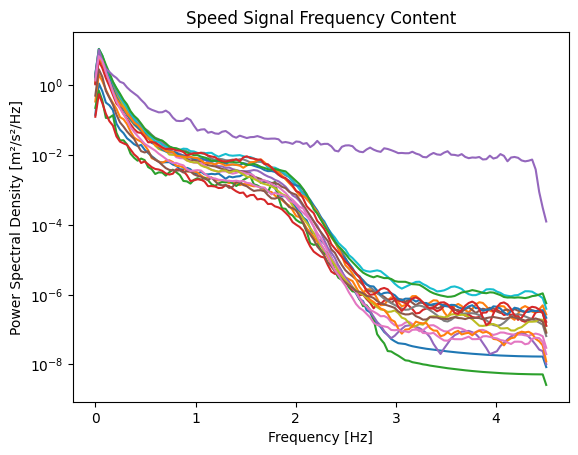

In [8]:
calculate_noise_metrics(filtered_df)

running_weighted_path_length_ratio = 0
number_of_samples = 0

for pid in participation_ids:
    is_ball = (pid == 'ball')
    participant_filtered_df = filtered_df[filtered_df['participation_id'] == pid]
    participant_df = df[df['participation_id'] == pid]

    if is_ball:
        path_length_ratio = noise.path_length_ratio(
            participant_df['Pitch_x'], participant_df['Pitch_y'],
            participant_filtered_df['Pitch_x'], participant_filtered_df['Pitch_y']
        )
        print(f'\nBall path length ratio: {path_length_ratio}')
    else:
        number_of_participant_samples = len(participant_df)
        path_length_ratio = noise.path_length_ratio(
            participant_df['Pitch_x'], participant_df['Pitch_y'],
            participant_filtered_df['Pitch_x'], participant_filtered_df['Pitch_y']
        )

        running_weighted_path_length_ratio += path_length_ratio * number_of_participant_samples
        number_of_samples += number_of_participant_samples

print(f'Total weighted player path length ratio: {running_weighted_path_length_ratio / number_of_samples}')

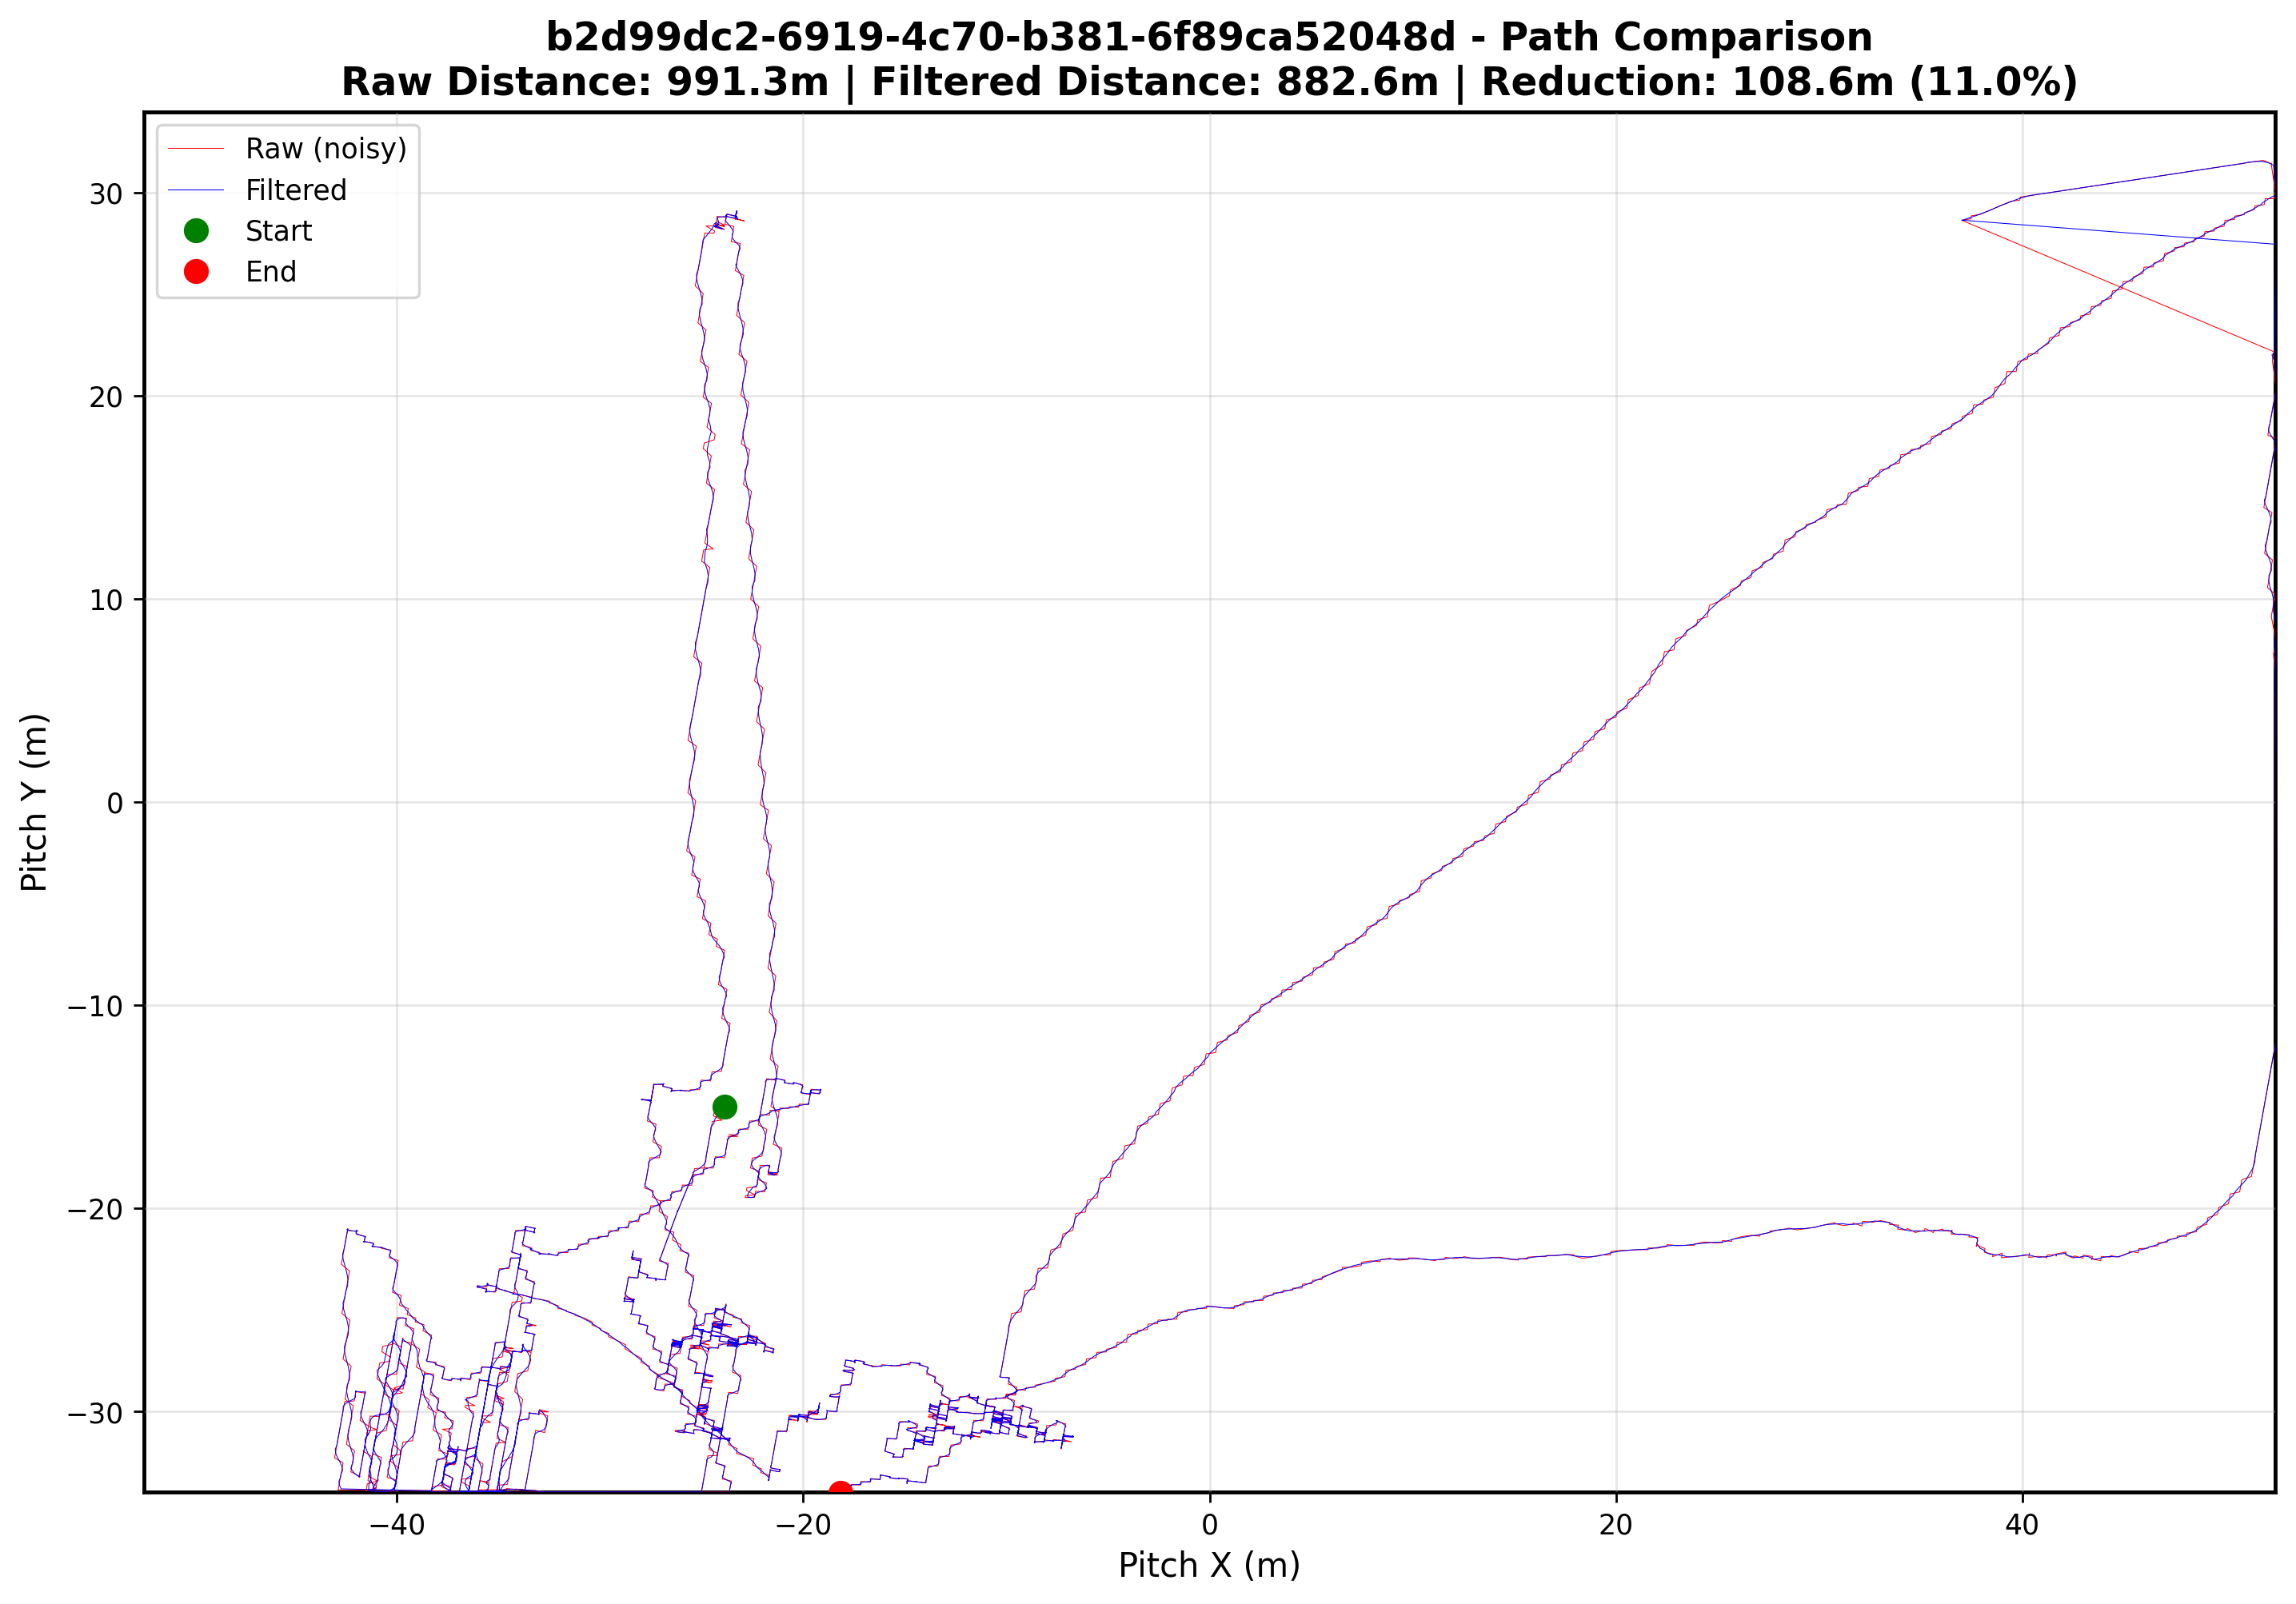

In [18]:
import lib.visualisations as visual

participant_id = participation_ids[3]

participant_df = df[df['participation_id'] == participant_id]
participant_filtered_df = filtered_df[filtered_df['participation_id'] == participant_id]

fig = visual.visualise_path_comparison(
    participant_df['Pitch_x'].values, participant_df['Pitch_y'].values,
    participant_filtered_df['Pitch_x'].values, participant_filtered_df['Pitch_y'].values,
    player_id=participant_id
)
fig.dpi = 250

## 